<a href="https://colab.research.google.com/github/sflyranger/Spam-Detection-Pipelines-/blob/main/Spam_Detection_Model__Small_Data_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='Pickle'>Spam Detection Modeling on Imbalanced Data</font>**

This notebook serves as a practical guide for building a classification model using pipelines. The process is broken down into two main parts:

- **<font color='Pickle'>Pipeline Creation:</font>** In this first portion, I’ll be creating **three separate pipelines** using smaller samples of the dataset. Each pipeline will be designed to address the challenges of working with imbalanced data, particularly in the context of spam detection.
  
- **<font color='Pickle'>Model Selection & Final Pipeline:</font>** The second notebook will focus on evaluating the performance of these three pipelines. I’ll select the **best-performing model** from the three and use it to create a final, robust pipeline. This final pipeline will be trained on a **larger random sample** of the dataset to enhance the model’s generalization and effectiveness.

This structured approach ensures that we carefully evaluate multiple strategies before committing to the final model, especially given the complexities of working with imbalanced data in spam detection.

In [1]:
# Import necessary libraries
import pandas as pd
from pathlib import Path
import sys
import spacy
import numpy as np
import matplotlib.pyplot as plt

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve


# XGB classifier import
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

# Import required stopwords
import nltk
from nltk.corpus import stopwords as nltk_stopwords  # Stopwords corpus
nltk.download('stopwords')  # Download the stopwords corpus

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix
# importing counter for class distributions
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')


    !pip install -U nltk -qq # -U ensures the most updated version
    !pip install -U spacy -qq # -qq limits the output commands to only the most important messages
    !python -m spacy download en_core_web_sm -qq # Small model from spacy
    !pip install -U pyspellchecker -qq. #pyspell checker for extendedmanualfeatures class
    # set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

    sys.path.append('/content/drive/MyDrive/Colab Notebooks/custom-functions')# enabling custom function usage

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 17.0 MB/s eta 0:00:00


In [4]:
# Double checking path
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/content/drive/MyDrive/Colab Notebooks/custom-functions']

In [5]:
# Appending the data set path
base_folder = Path(base_path)
data_folder = base_folder/'datasets/spam_ds'
model_folder = base_folder/'models/nlp_fall_2024/spam'

In [6]:
# Making the directory for my models in google drive.
model_folder.mkdir(parents=True, exist_ok=True)

In [7]:
# location of the spam data set
spam_file = data_folder/'spam.csv'

# Creating the dataframe object for the Spam data set
spam_df = pd.read_csv(spam_file, encoding='ISO-8859-1')

<font color='Pickle'> **We can see below that there are three additional columns within the data-set that have no meaning. I will start by renaming the v1 and v2 columns to label and message respectively then deleting the 3 unnamed columns.**</font>

In [8]:
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
# Setting up label encoder for future use
label_encoder = LabelEncoder()

In [10]:
# Renaming
spam_df= spam_df.rename(columns = {'v1': 'label','v2': 'message'})

# Deleting
spam_df = spam_df.drop(columns = {'Unnamed: 2','Unnamed: 3','Unnamed: 4'})

# Resetting index
spam_df = spam_df.reset_index(drop = True)

# New df
spam_df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
print('Spam Data Shape:', spam_df.shape)

Spam Data Shape: (5572, 2)


In [12]:
# Finding percentages of ham and spam
spam_df['label'].value_counts(normalize = True) # Normalize shows the proportion.

,proportion
label,
ham,0.865937
spam,0.134063


<font color='Pickle'>**Observations on Class Imbalance**</font>

We can observe a <font color='Pickle'>**significant class imbalance**</font> in the dataset:

- <font color='Pickle'>**Ham**:</font> Represents the proportion of email messages that are not spam, making up approximately **87%** of the dataset.
- <font color='Pickle'>**Spam**:</font> Represents the spam emails, accounting for only about **13%** of the data.

This imbalance highlights the need for careful consideration in model training to ensure that the <font color='Pickle'>**minority class (Spam)**</font> is adequately represented and that the model doesn't become biased towards the <font color='Pickle'>**majority class (Ham)**</font>.


# **<font color='Pickle'>Metric for Evaluating the Model:**

## **<font color='Pickle'>F1 Score**

Given the stark class imbalance between Spam and Ham, it's crucial to select the most appropriate metric for evaluating our model, as the traditional metric of accuracy will not suffice. Always predicting messages as ham would yield an accuracy of 87%, but this wouldn't truly reflect the model's performance in classifying spam.

The optimal metric for this situation is the **<font color='Pickle'>F1 Score</font>**, a harmonic mean of two critical metrics: **<font color='Pickle'>Precision</font>** and **<font color='Pickle'>Recall</font>**.

### **<font color='Pickle'>Precision</font>**
Precision is calculated using the formula:

<font color='Pickle'>**Precision = TP / (TP + FP)**</font>

where:
- **<font color='Pickle'>TP</font>** (True Positives): The number of correctly classified spam messages.
- **<font color='Pickle'>FP</font>** (False Positives): The number of messages incorrectly classified as spam.

A high **<font color='Pickle'>Precision</font>** value indicates that the model makes few mistakes when predicting positive instances (i.e., spam).

### **<font color='Pickle'>Recall</font>**
Recall (also known as sensitivity or true positive rate) is the ratio of true positive predictions to the total number of actual positive instances within the dataset. It is represented by the formula:

<font color = 'Pickle'>**Recall = TP / (TP + FN)**

where:
- **<font color='Pickle'>FN</font>** (False Negatives): The number of messages that are actually spam but have been incorrectly classified as ham.

**<font color='Pickle'>Recall</font>** answers the question: "Out of all the positive instances in the dataset, how many did we correctly predict?"

### **<font color='Pickle'>F1 Score</font>**
The **<font color='Pickle'>F1 Score</font>**, as mentioned above, is the harmonic mean of **<font color='Pickle'>Precision</font>** and **<font color='Pickle'>Recall</font>**, represented by the formula:

**<font color='Pickle'> F1 Score = 2(Precision x Recall) / (Precision + Recall)**

The harmonic mean is used here because it gives greater weight to lower values. This means that the **<font color='Pickle'>F1 Score</font>** will only be high if both **<font color='Pickle'>precision</font>** and **<font color='Pickle'>recall</font>** are high. If either metric is low, then the **<font color='Pickle'>F1 score</font>** will also be low. This ensures that a model with a precision of 0.8 and recall of 0.1 will have a lower **<font color='Pickle'>F1 score</font>** than a model with a precision and recall both at 0.6.






# **<font color='Pickle'>Classification Pipelines**
Below I am creating three model Pipelines to test which is most effective at classification. Each Pipeline will be evaluated on 10% of the full data set. After I evaluate each model I will create a second notebook to use the best model weights to train a model on a randomly selected 40% of the data where it will then be evaluated on a test set of un-seen data.




### <font color ='pickle'>**Creating Pipeline data subsets**

In [13]:
# Sampling for Sparse Embedding Pipeline
sparse_df = spam_df.sample(frac = 0.1,random_state = 42)

# Feature Engineering Pipeline sampling
fe_df = sparse_df

# Feature engineering and Sparse Embedding Pipeline
s_fe_df = sparse_df


# **<font color='Pickle'>Pipeline 1: Preprocessing + Sparse Embeddings Pipeline + ML model</font>**

## **<font color='Pickle'>For this pipeline, I will:</font>**

- Sample 10% of the entire dataset.
- Split the subset into train and test sets.
- Preprocess the data using the Spacy preprocessor
- Create the data pipeline that uses a <font color = 'Pickle'>**TFIDF vectorizer**</font> and an <font color ='Pickle'>**XGBoost**</font> model.
- Train the hyperparameters of the model using <font color = 'Pickle'>**RandomSearchCV**</font> and 5-fold cross-validation.
- Fit the best parameters on the training data to evaluate the model.
- Plot the learning curves of the model based on a model performance metric <font color = 'Pickle'>**(F1 score)**</font>
- Evaluate the model on the test data set by printing the classification report.




In [14]:
# Splitting into training and temp data
train_s_df,test_s_df = train_test_split(sparse_df, test_size = 0.4, random_state = 42)

In [15]:
print('Train class distribution:',train_s_df['label'].value_counts())

print('-'*30)
print('Test class distribution:',test_s_df['label'].value_counts())


Train class distribution: label
ham     303
spam     31
Name: count, dtype: int64
------------------------------
Test class distribution: label
ham     187
spam     36
Name: count, dtype: int64


In [16]:
# Seperating independent and dependent columns and Label Encoding
X_train_s = train_s_df['message'].values
X_test_s = test_s_df['message'].values

y_train_s = train_s_df['label'].values
y_test_s = test_s_df['label'].values

y_train_s_encoded = label_encoder.fit_transform(y_train_s)
y_test_s_encoded = label_encoder.transform(y_test_s)

# Checking class distributions
train_distribution = Counter(y_train_s_encoded)
print("Training set distribution:", train_distribution)

test_distribution = Counter(y_test_s_encoded)
print("Test set distribution:", test_distribution)

Training set distribution: Counter({0: 303, 1: 31})
Test set distribution: Counter({0: 187, 1: 36})


In [17]:
# import custom-preprocessor from python file
import CustomPreprocessorSpacy as cp

In [18]:
cp.SpacyPreprocessor?

###<font color='Pickle'>**The Spacy Preprocessor above is a full text preprocessing class allowing for multiple parameters.**</font>

For full documentation refer to this link. https://github.com/explosion/spacy-models/releases/tag/en_core_web_sm-3.7.1

#### **<font color='Pickle'>Attributes:**

- **<font color='Pickle'>`model`</font>** *(str)*:  
  The spaCy language model to be used for tokenization and other NLP tasks.

- **<font color='Pickle'>`batch_size`</font>** *(int)*:  
  The number of documents to process at once during spaCy's pipeline processing.

- **<font color='Pickle'>`lemmatize`</font>** *(bool)*:  
  If `True`, lemmatize tokens.

- **<font color='Pickle'>`lower`</font>** *(bool)*:  
  If `True`, convert all characters to lowercase.

- **<font color='Pickle'>`remove_stop`</font>** *(bool)*:  
  If `True`, remove stopwords.

- **<font color='Pickle'>`remove_punct`</font>** *(bool)*:  
  If `True`, remove punctuation.

- **<font color='Pickle'>`remove_email`</font>** *(bool)*:  
  If `True`, remove email addresses.

- **<font color='Pickle'>`remove_url`</font>** *(bool)*:  
  If `True`, remove URLs.

- **<font color='Pickle'>`remove_num`</font>** *(bool)*:  
  If `True`, remove numbers.

- **<font color='Pickle'>`stemming`</font>** *(bool)*:  
  If `True`, apply stemming to tokens *(mutually exclusive with lemmatization)*.

- **<font color='Pickle'>`add_user_mention_prefix`</font>** *(bool)*:  
  If `True`, add `'@'` as a separate token *(useful for user mentions in social media data)*.

- **<font color='Pickle'>`remove_hashtag_prefix`</font>** *(bool)*:  
  If `True`, do not separate `'#'` from the following text.

- **<font color='Pickle'>`basic_clean_only`</font>** *(bool)*:  
  If `True`, perform only basic cleaning *(HTML tags removal, line breaks, etc.)* and ignore other preprocessing steps.



###<font color='Pickle'>**Preprocessing**


In [30]:
# Using the custom Spacy preprocessor to clean the train and test data,
X_train_cleaned_s = cp.SpacyPreprocessor(model = 'en_core_web_sm',batch_size = 100).transform(X_train_s)
X_test_cleaned_s = cp.SpacyPreprocessor(model = 'en_core_web_sm',batch_size = 100).transform(X_test_s)

# Creating filepaths in drive
file_X_train_cleaned_s = data_folder/'X_train_cleaned_sparse.pkl'
file_X_test_cleaned_s = data_folder/'X_test_cleaned_sparse.pkl'

# Uploading pkl files to drive
joblib.dump(X_train_cleaned_s, file_X_train_cleaned_s)
joblib.dump(X_test_cleaned_s, file_X_test_cleaned_s)

In [39]:
# Creating filepaths in drive
file_X_train_cleaned_s = data_folder/'X_train_cleaned_sparse.pkl'
file_X_test_cleaned_s = data_folder/'X_test_cleaned_sparse.pkl'

### <font color='Pickle'>**Pipeline Set Up**</font>

- Using the TF-IDF vectorizer with the following hyperparameters:
  - **<font color='Pickle'>`min_df = 2`</font>**: This ensures that terms must appear in at least 2 documents to be considered. This helps in filtering out very rare words that might not contribute meaningfully to the model.
  - **<font color='Pickle'>`max_df = 100`</font>**: Terms that appear in more than 100 documents are excluded. This helps in removing extremely common words or phrases that are too frequent to be useful in distinguishing between spam and non-spam.
  - **<font color='Pickle'>`token_pattern = r"\b\w[\w@#.!?]*\b"`</font>**: This pattern is designed to capture a wide range of tokens, including words with special characters like `@`, `#`, `.` and `!`. It helps in recognizing abnormal spellings and patterns that are often indicative of spam.
  - **<font color='Pickle'>`max_features = 1000`</font>**: Limits the number of features (terms) to the top 1000 based on term frequency. This reduces the dimensionality of the feature space while keeping the most informative terms.
  - **<font color='Pickle'>`ngram_range = (1, 3)`</font>**: Extracts unigrams, bigrams, and trigrams. This helps capture common phrases and sequences like "You won a" or "Congratulations you win," which are often used in spam emails.
  - **<font color='Pickle'>`stop_words = None`</font>**: No stopwords are removed. Stopwords are retained because common phrases that include stopwords can be indicative of spam, such as "click here" or "you have won."
  - **<font color='Pickle'>`lowercase = False`</font>**: Text is not converted to lowercase, allowing the model to differentiate between capitalized and uncapitalized versions of words, which might be important in identifying spam (e.g., "FREE" vs. "free").



In [19]:
# Importing the nltk stopwords library
nltk_stop_words = nltk_stopwords.words('english')

In [ ]:
classifier_1 = Pipeline([
    ('vectorizer',TfidfVectorizer(min_df = 2,
                                   max_df = 100,
                                   token_pattern =r"\b\w[\w@#.!?]*\b",
                                   max_features = 1000,
                                   ngram_range = (1,3), # Pulls in bigrams and trigrams for common phrasing such as 'You won a','Congratulations you win', etc.
                                   stop_words = None, # Stop words can be helpful in classifying spam emails because of common phrases.
                                   lowercase = False # Keeping both capitalized and uncapitalized versions of words.
                                   )),
    ('classifier',XGBClassifier(enable_categorical=True, eval_metric = 'logloss'))
])

### <font color='Pickle'>**Hyperparameter Tuning Setup**</font>

- Using `RandomizedSearchCV` to tune the following hyperparameters:

  - **<font color='Pickle'>`vectorizer__max_features`</font>**:
    - **Values:** `[300, 500, 700, 1000]`
    - **Explanation:** Controls the number of features (terms) considered by the TF-IDF vectorizer. This range helps explore different levels of feature dimensionality, allowing the model to capture the most relevant terms.

  - **<font color='Pickle'>`classifier__n_estimators`</font>**:
    - **Values:** `[20, 50, 100]`
    - **Explanation:** Determines the number of boosting rounds in the XGBoost model. More boosting rounds can increase model complexity, allowing the model to learn more intricate patterns in the data.

  - **<font color='Pickle'>`classifier__learning_rate`</font>**:
    - **Values:** `[0.01, 0.1, 0.2]`
    - **Explanation:** Sets the learning rate for each boosting round. Lower values make the model update more cautiously, which can help prevent overfitting, especially in smaller datasets.

  - **<font color='Pickle'>`classifier__max_depth`</font>**:
    - **Values:** `[3, 5, 7]`
    - **Explanation:** Controls the maximum depth of the trees in the XGBoost model. Deeper trees allow the model to capture more complex patterns, but they also increase the risk of overfitting.

  - **<font color='Pickle'>`classifier__scale_pos_weight`</font>**:
    - **Values:** `[1, 10, 25, 50, 75, 99, 100, 1000]`
    - **Explanation:** Adjusts the balance between positive and negative classes to handle class imbalance. The wide range of values allows exploration of how much emphasis should be placed on the minority class to achieve better classification results.


In [ ]:
param_grid_classifier_1 = {
    'vectorizer__max_features':[300,500,700,1000], # Number of features to consider in the RandomSearch for TF-IDF
    'classifier__n_estimators': [20,50,100], # Number of boosting rounds in XGB
    'classifier__learning_rate': [0.01,0.1,0.2], # Learning rate for each boosting round
    'classifier__max_depth': [3,5,7,9,11], # Maximum depth of trees (higher values make the model more complex)
    'classifier__scale_pos_weight': [1,10,25,50,75,99,100,1000] # Class weight values to handle the class imbalance and some for exploration.
}


### <font color='Pickle'>**Cross-Validation and Hyperparameter Tuning**</font>

- **Cross-Validation Strategy**: Using **<font color='Pickle'>`RepeatedStratifiedKFold`</font>** with 5 splits and 1 repeat to ensure balanced class distribution across folds.
  
- **Hyperparameter Tuning with RandomizedSearchCV**:
  - **Iterations**: Testing **<font color='Pickle'>`10`</font>** different hyperparameter combinations.
  - **Scoring Metric**: Using **<font color='Pickle'>`f1_macro`</font>** to address class imbalance.
  - **Parallel Processing**: Set **<font color='Pickle'>`n_jobs=-1`</font>** to utilize all available CPU cores.
  - **Verbose Level**: Set to **<font color='Pickle'>`2`</font>** to provide detailed output for better understanding.


In [ ]:
cv_strategy = RepeatedStratifiedKFold(n_splits = 5,n_repeats = 1, random_state = 42)

grid_classifier_1 = RandomizedSearchCV(
    estimator = classifier_1,
    param_distributions = param_grid_classifier_1,
    n_iter =300,# Number of different combinations to try
    cv=cv_strategy,
    scoring = 'f1_macro', #F1 scoring metric within the CV
    verbose = 2, # Showing output for personal understanding
    n_jobs = -1 # Ensureing the use of all available cores.
)

###<font color='Pickle'>**Fitting model**

In [ ]:
X_train_cleaned_s = joblib.load(file_X_train_cleaned_s)
grid_classifier_1.fit(X_train_cleaned_s, y_train_s_encoded)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(lowercase=False,
                                                              max_df=100,
                                                              max_features=1000,
                                                              min_df=2,
                                                              ngram_range=(1,
                                                                           3),
                                                              token_pattern='\\b\\w[\\w@#.!?]*\\b')),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            co...
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7, 9,
                                                                  11],
                                        'classifier__n_estimators': [20, 50,
                                                                     100],
                                        'classifier__scale_pos_weight': [1, 10,
                                                                         25, 50,
                                                                         75, 99,
                                                                         100,
                                                                         1000],
                                        'vectorizer__max_features': [300, 500,
                                                                     700,
                                                                     1000]},
                   scoring='f1_macro', verbose=2)

##<font color = 'Pickle'>**Understanding XGBoost's Log Loss and F1 Scoring**

### <font color = 'Pickle'>**Why Doesn't XGBoost Include F1 Scoring?**

When working with the **<font color='Pickle'>XGBoost</font>** model, it's important to understand that it primarily optimizes **<font color='Pickle'>log loss</font>** during training. **<font color='Pickle'>Log loss</font>**, or logistic loss, is a common objective function for binary classification tasks, and it helps the model learn to predict probabilities that are well-calibrated.

### <font color = 'Pickle'>**But What About F1 Score?**

Even though I'm using **<font color='Pickle'>f1_macro</font>** as the scoring metric in **<font color='Pickle'>RandomizedSearchCV</font>**, this doesn't mean **<font color='Pickle'>XGBoost</font>** is optimizing the **<font color='Pickle'>F1 score</font>** during training. Instead, **<font color='Pickle'>XGBoost</font>** sticks to optimizing **<font color='Pickle'>log loss</font>** because it's a differentiable function, which is essential for gradient-based optimization algorithms like **<font color='Pickle'>XGBoost</font>**.

The **<font color='Pickle'>F1 score</font>**, on the other hand, is not differentiable, which makes it unsuitable as a direct loss function. However, that doesn't mean it's not useful—quite the opposite! By using **<font color='Pickle'>F1</font>** as the scoring metric in **<font color='Pickle'>RandomizedSearchCV</font>**, I'm making sure that the model configuration that performs best is one that balances precision and recall, which is crucial for my imbalanced dataset.

### <font color = 'Pickle'>**How Does This Work in Practice?**

- **During Training:** **<font color='Pickle'>XGBoost</font>** optimizes the **<font color='Pickle'>log loss</font>** function to learn the best model parameters.
- **During Hyperparameter Tuning:** **<font color='Pickle'>RandomizedSearchCV</font>** evaluates each model configuration using the **<font color='Pickle'>F1 score</font>** (or whichever metric I specify). This way, the model that is selected is the one that performs best in terms of **<font color='Pickle'>F1 score</font>**, even though it was trained using **<font color='Pickle'>log loss</font>**.

### <font color = 'Pickle'>**Why This Makes Sense**

Using **<font color='Pickle'>log loss</font>** for training helps the model become confident in its probability predictions, while evaluating it with **<font color='Pickle'>F1 score</font>** ensures that I'm picking a model that effectively handles the class imbalance in my data. It's a balanced approach that leverages the strengths of both metrics to improve model performance.




##<font color = 'Pickle'>**Getting the best Parameters**

In [ ]:
print(f'Best cross-validation score: {grid_classifier_1.best_score_:.2f}')
print("\nBest Parameters:",grid_classifier_1.best_params_)
print("\nBest Estimator:", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.85

Best Parameters: {'vectorizer__max_features': 700, 'classifier__scale_pos_weight': 100, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2}

Best Estimator: Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, max_df=100, max_features=700,
                                 min_df=2, ngram_range=(1, 3),
                                 token_pattern='\\b\\w[\\w@#.!?]*\\b')),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categoric...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                    

###<font color = 'Pickle'>**Saving the model**

In [ ]:
file_best_estimator_pipeline1 = model_folder/'pipeline1_sparse_best_estimator.pkl'

file_complete_grid_pipeline1 = model_folder/'pipeline1_sparse_complete_grid.pkl'

joblib.dump(grid_classifier_1.best_estimator_, file_best_estimator_pipeline1)
joblib.dump(grid_classifier_1, file_complete_grid_pipeline1)

['/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/spam/pipeline1_sparse_complete_grid.pkl']

###<font color = 'Pickle'>**Reload the model**

In [ ]:
best_estimator_pipeline1 = joblib.load(file_best_estimator_pipeline1)

complete_grid_pipeline1 = joblib.load(file_complete_grid_pipeline1)


### **Why Save and Reload the Model?**

1. **<font color='Pickle'>Efficiency</font>:**
   - After running **<font color='Pickle'>`RandomizedSearchCV`</font>**, I save the best model and grid search results using **<font color='Pickle'>`joblib`</font>**. Hyperparameter tuning is computationally expensive, and by saving the outputs, I can avoid repeating the time-consuming process. Reloading these saved objects later allows me to focus on analyzing the results, like plotting learning curves, without the need to rerun the entire tuning process.

2. **<font color='Pickle'>Reproducibility</font>:**
   - Saving and reloading the best model ensures consistency in my results. By working with the exact model configuration identified as the best, I avoid any variations that could arise from rerunning the grid search. This approach maintains the integrity of my analysis, especially when I need to reproduce or share my findings.

3. **<font color='Pickle'>Experiment Management</font>:**
   - In complex experiments involving multiple models or stages, saving intermediate results helps me keep everything organized. It’s easier to revisit specific parts of my experiment without having to rerun everything from scratch. This method allows me to separate the computationally intensive tasks from the analysis, making my workflow more modular and manageable.


###<font color = 'Pickle'>**Plotting the learning curve**

In [58]:
from plot_learning_curve import plot_learning_curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

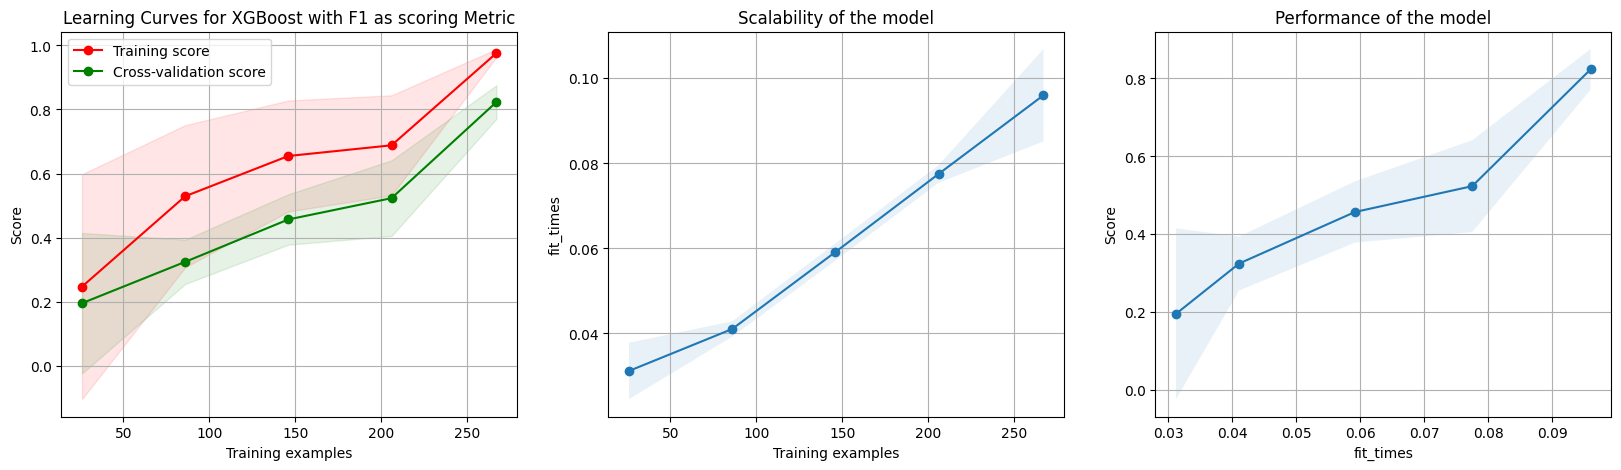

In [ ]:
plot_learning_curve(
    best_estimator_pipeline1,
    'Learning Curves for XGBoost with F1 as scoring Metric',
    X_train_cleaned_s,
    y_train_s_encoded,
    scoring = 'f1_macro',
    n_jobs = -1)

###<font color = 'Pickle'>**Observations**
- **<font color='Pickle'>Learning Curve:</font>**
   - The **<font color='Pickle'>training</font>** score starts at a low point and increases rapidly as more training examples are introduced into the model. This is an indicator that the model is learning well from the training data set. It rises to an almost perfect score near the end suggesting an **<font color='indianred'>overfit.</font>**

   - The **<font color='Pickle'>CV</font>** curve follows a similar pattern improving with more examples but at a slightly lower rate, indicating a lower ability to generalize as more data is added. We can also see how the distance between the curves rises but stays fairly consistent.
- **<font color='Pickle'>Scalability:</font>**
   - This plot shows how scalable the model is with more data. The fit times here are increasing in a linear pattern as more data is added. The increase seems steady so the model will scale well with the dataset.
- **<font color='Pickle'>Model Performance:</font>**
   - The plot shows how the **<font color='Pickle'>model performance</font>** improves as the time for fitting increases. We can see a relatively consistent increase in the score as the training time increases but there is quite a bit of variation so we can't trust the fit times alone to capture the models performance variability.
   

###<font color = "Pickle">**Checking Cross Validation Scores and Train Scores**

In [ ]:
print('Train scores:',best_estimator_pipeline1.score(X_train_cleaned_s,y_train_s_encoded))

print('Cross Validation Scores:', complete_grid_pipeline1.best_score_)

Train scores: 0.9910179640718563
Cross Validation Scores: 0.8549152241620905


###<font color = 'Pickle'>**Evaluating on the Testing data set**

In [ ]:
# Last Pipeline
def final_pipeline(text):
  cleaned_text = joblib.load(file_X_test_cleaned_s) # Pulling in the cleaned and preprocessed testing data
  best_estimator_pipeline1 = joblib.load(file_best_estimator_pipeline1) # pulling in the best model parameters
  predictions =best_estimator_pipeline1.predict(cleaned_text)
  return predictions


In [ ]:
y_test_pred_s = final_pipeline(X_test_s)

###<font color = 'Pickle'>**Classification Report**

In [ ]:
print('Sparse embeddings model metrics through the tfidf vectorizer:\n\n', classification_report(y_test_s_encoded, y_test_pred_s))

Sparse embeddings model metrics through the tfidf vectorizer:

               precision    recall  f1-score   support

           0       0.94      0.96      0.95       187
           1       0.75      0.67      0.71        36

    accuracy                           0.91       223
   macro avg       0.84      0.81      0.83       223
weighted avg       0.91      0.91      0.91       223



### **Model Interpretation Summary**

- **Class 0 (Ham - Majority Class):**
  - **<font color='Pickle'>Precision (0.94):</font>** The model correctly identifies 94% of ham emails, making it highly reliable in avoiding false positives for non-spam emails.
  - **<font color='Pickle'>Recall (0.96):</font>** With a recall of 96%, the model is doing an excellent job of capturing nearly all ham emails, missing only a small fraction.
  - **<font color='Pickle'>F1-Score (0.95):</font>** The F1-score, which balances precision and recall, is very high, indicating strong performance on the majority class.

- **Class 1 (Spam - Minority Class):**
  - **<font color='Pickle'>Precision (0.75):</font>** When the model predicts an email as spam, it’s accurate 75% of the time, meaning that 25% of the emails classified as spam are actually not spam emails (false positives).
  - **<font color='Pickle'>Recall (0.67):</font>** The model successfully identifies 67% of the actual spam emails, indicating that it’s missing about one-third of spam instances.
  - **<font color='Pickle'>F1-Score (0.71):</font>** Since both precision and recall for spam are around 70%, the F1-score, which is the harmonic mean of these two metrics, is approximately 0.71. This reflects the model’s balanced but moderate performance on the minority class.

- **Overall Takeaway:**
  - The model excels in identifying **<font color='Pickle'>ham</font>** emails, as expected, but the **<font color='Pickle'>spam</font>** class shows decent precision with a need for improved recall. The F1-score for spam highlights the balance between precision and recall, but further enhancements could push this value higher, leading to better overall spam detection.



# **<font color='Pickle'>Pipeline 2: Preprocessing + Manual Feature Engineering + ML Model Pipeline</font>**

## **<font color='Pickle'>For this pipeline, I will:</font>**

- Use 10% of the entire dataset.
- Split the subset into train and test sets.
- Preprocess the data using the Spacy preprocessor.
- **<font color='Pickle'>Generate manual features</font>** such as the count of words, characters, digits, exclamation marks, numbers, nouns, proper nouns, auxiliary verbs (AUX), verbs, adjectives, named entities, spelling mistakes, and others of my choosing.
- Create the data pipeline that integrates these engineered features along with an <font color='Pickle'>**XGBoost**</font> model.
- Train the hyperparameters of the model using <font color='Pickle'>**GridSearchCV**</font> with 5-fold cross-validation.
- Fit the best parameters on the training data to evaluate the model.
- Plot the learning curves of the model based on a model performance metric <font color='Pickle'>**(F1 score)**</font>.
- Evaluate the model on the test dataset by printing the classification report.


In [20]:
# Resetting the training and testing data to use for the manual features
train_fe_df,test_fe_df = train_s_df,test_s_df

In [21]:
print('Train class distribution:',train_fe_df['label'].value_counts())

print('-'*30)
print('Test class distribution:',test_fe_df['label'].value_counts())

Train class distribution: label
ham     303
spam     31
Name: count, dtype: int64
------------------------------
Test class distribution: label
ham     187
spam     36
Name: count, dtype: int64


In [22]:
# Seperating indep and dependent columns and encoding
X_train_fe = train_fe_df['message'].values
X_test_fe = test_fe_df['message'].values

y_train_fe = train_fe_df['label'].values
y_test_fe = test_fe_df['label'].values

y_train_fe_encoded = label_encoder.fit_transform(y_train_fe)
y_test_fe_encoded = label_encoder.transform(y_test_fe)

# Checking class distribution
train_distribution = Counter(y_train_fe_encoded)
print('Training distribution:',train_distribution)

test_distribution = Counter(y_test_fe_encoded)
print('Test distribution:',test_distribution)

Training distribution: Counter({0: 303, 1: 31})
Test distribution: Counter({0: 187, 1: 36})


###<font color = 'Pickle'>**Generating Manual Features**
- Note the usage of False for each of the parameters for the Spacy Preprocessor, this is because I will be adding my own manual features.

In [25]:
# Cleaning the training set via SpacyPreprocessor
X_train_cleaned_fe = cp.SpacyPreprocessor(model = 'en_core_web_sm',
                                          lemmatize =False,
                                          lower = False, remove_stop = False,
                                          remove_punct = False,remove_email = False,
                                          remove_url = False, add_user_mention_prefix = False,
                                          basic_clean_only = True).transform(X_train_fe)
# Cleaning the testing set
X_test_cleaned_fe = cp.SpacyPreprocessor(model = 'en_core_web_sm',
                                         lemmatize =False,
                                          lower = False, remove_stop = False,
                                          remove_punct = False,remove_email = False,
                                          remove_url = False, add_user_mention_prefix = False,
                                          basic_clean_only = True).transform(X_test_fe)
# Saving our files for later use
file_X_train_cleaned_fe = data_folder/'X_train_cleaned_fe.pkl'
file_X_test_cleaned_fe = data_folder/'X_test_cleaned_fe.pkl'

# Dumping files to drive
joblib.dump(X_train_cleaned_fe,file_X_train_cleaned_fe)
joblib.dump(X_test_cleaned_fe,file_X_test_cleaned_fe)

/content/drive/MyDrive/Colab Notebooks/custom-functions/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


['/content/drive/MyDrive/Colab Notebooks/datasets/spam_ds/X_test_cleaned_fe.pkl']

In [23]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.8 MB/s eta 0:00:00


In [23]:
from FeaturizerSpacy import ExtendedManualFeatures

In [ ]:
ExtendedManualFeatures??

### **<font color='Pickle'>Summary of Edits to the `ManualFeatures` Class</font>**

- Below are the enhancements made to the original `ManualFeatures` class to implement a spellchecker.
- The new method processes the `cleaned_text` input, **<font color='Pickle'>tokenizes</font>** the text into individual words, and uses the **<font color='Pickle'>SpellChecker</font>** object to identify and count misspelled words in each document.
- This misspelled word count is then integrated into the feature set through the `transform` method.
- The **<font color='Pickle'>transform method</font>** first calls the parent class's transform method to generate the base features and feature names.
- It then appends the misspelled word count as a new feature, resulting in an updated array of features and names, including the new feature called `misspelled_count`.


```python
class ExtendedManualFeatures(ManualFeatures):
    def __init__(self, spacy_model, batch_size=64, pos_features=True, ner_features=True, text_descriptive_features=True, spellcheck_features=True):
        super().__init__(spacy_model, batch_size, pos_features, ner_features, text_descriptive_features)
        self.spellcheck_features = spellcheck_features
        self.spell = SpellChecker()

    def get_spellcheck_features(self, cleaned_text):
        misspelled_count = []

        for doc in cleaned_text:
            tokens = doc.split()  # Simple tokenization
            misspelled = self.spell.unknown(tokens)  # Identify misspelled words
            misspelled_count.append(len(misspelled))

        return np.array(misspelled_count).reshape(-1, 1)

    def transform(self, X, y=None):
        # Use the transform method from the parent class
        features, feature_names = super().transform(X)

        if self.spellcheck_features:
            spellcheck_features = self.get_spellcheck_features(X)
            feature_names.append('misspelled_count')
            features = np.hstack((features, spellcheck_features))

        return features, feature_names


In [27]:
featurizer = ExtendedManualFeatures(spacy_model = 'en_core_web_sm',batch_size = 1000)

###<font color = 'Pickle'>**Reloading and fitting the featurizer on train**

In [28]:
X_trained_cleaned_fe = joblib.load(file_X_train_cleaned_fe)
X_train_fe_features, feature_names = featurizer.fit_transform(X_train_cleaned_fe)
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_numbers',
 'count_sentences',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner',
 'misspelled_count']

###<font color='Pickle'>**Pipeline**

In [27]:
classifier_2 = Pipeline([
    ('classifier',XGBClassifier(enable_categorical = True, eval_metric = 'logloss'))
])

###<font color='Pickle'>**Parameter Grid**

In [28]:
param_grid_classifier_2 = {
    'classifier__n_estimators': [20,50,100], # Number of boosting rounds in XGB
    'classifier__learning_rate': [0.01,0.1,0.2], # Learning rate for each boosting round
    'classifier__max_depth': [3,5,7,9,11], # Maximum depth of trees (higher values make the model more complex)
    'classifier__scale_pos_weight': [1,10,25,50,75,99,100,1000] # Class weight values to handle the class imbalance and some for exploration.
}

###<font color='Pickle'>**Specify Random Search**

In [29]:
cv_strategy = RepeatedStratifiedKFold(n_splits = 5,n_repeats = 1, random_state = 42)

grid_classifier_2 = RandomizedSearchCV(
    estimator = classifier_2,
    param_distributions = param_grid_classifier_2,
    n_iter = 300,
    cv = cv_strategy, #Random Stratified 5 fold
    scoring = 'f1_macro',
    verbose = 2,
    n_jobs = -1
)

###<font color = 'Pickle'>**Fitting the model**

In [30]:
# fitting on train
grid_classifier_2.fit(X_train_fe_features, y_train_fe_encoded)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=True,
                                                            eval_metric='logloss',
                                                            feature_types=...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7, 9,
                                                                  11],
                                        'classifier__n_estimators': [20, 50,
                                                                     100],
                                        'classifier__scale_pos_weight': [1, 10,
                                                                         25, 50,
                                                                         75, 99,
                                                                         100,
                                                                         1000]},
                   scoring='f1_macro', verbose=2)

###<font color = 'Pickle'>**Getting best parameters**

In [31]:
print('Best Cross validation:',{grid_classifier_2.best_score_}) # calling the best score attribute
print('\nBest Parameters:',grid_classifier_2.best_params_) #best param attribute
print('\nBest estimator:', grid_classifier_2.best_estimator_) # best estimator attribute

Best Cross validation: {0.9229371398596437}

Best Parameters: {'classifier__scale_pos_weight': 10, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2}

Best estimator: Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_dep

###<font color = 'Pickle'>**Saving the Model**

In [32]:
file_best_estimator_pipeline_2 = model_folder/'pipeline2_fe_best_estimator.pkl'

file_complete_grid_pipeline2 = model_folder/'pipeline2_fe_complete_grid.pkl'

joblib.dump(grid_classifier_2.best_estimator_, file_best_estimator_pipeline_2)

joblib.dump(grid_classifier_2,file_complete_grid_pipeline2)


['/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/spam/pipeline2_fe_complete_grid.pkl']

###<font color = 'Pickle'>**Reload the saved model**

In [33]:
best_estimator_pipeline2 = joblib.load(file_best_estimator_pipeline_2)

complete_grid_pipeline2 = joblib.load(file_complete_grid_pipeline2)

###<font color = 'Pickle'>**Plot the learning curve for the model**

In [34]:
from plot_learning_curve import plot_learning_curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

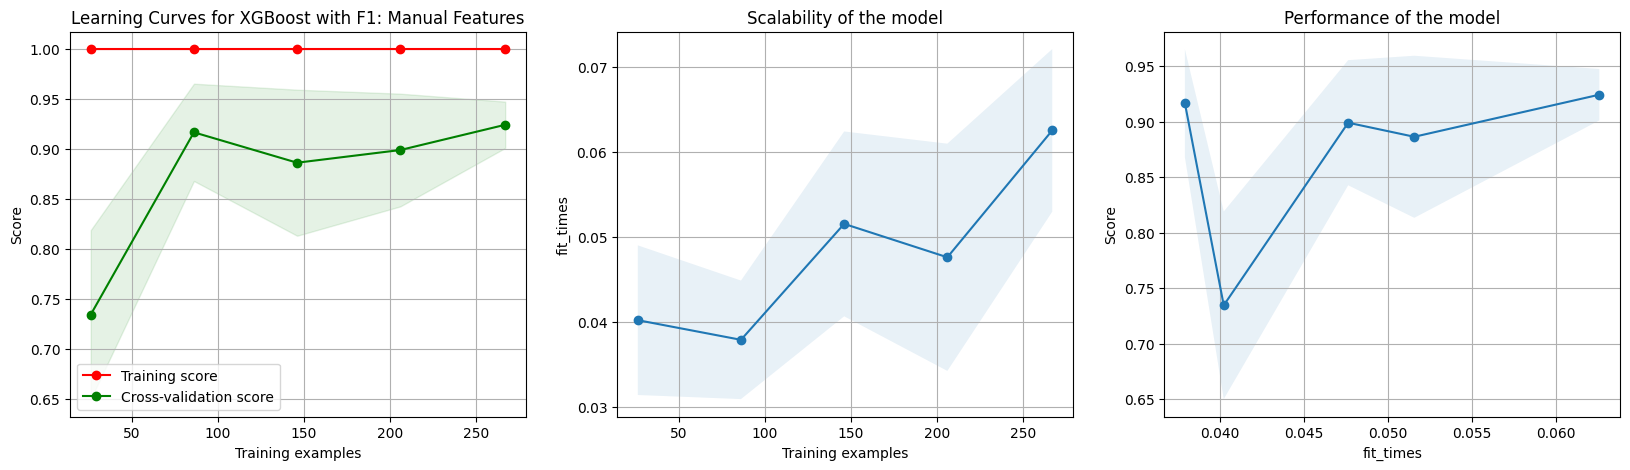

In [35]:
plot_learning_curve(
    best_estimator_pipeline2,
    'Learning Curves for XGBoost with F1: Manual Features',
    X_train_fe_features,
    y_train_fe_encoded,
    scoring = 'f1_macro',
    n_jobs = -1)


### **<font color='Pickle'>Observations</font>**

- **<font color='Pickle'>Learning Curve:</font>**  
  The model is clearly **<font color='indianred'>overfitting.</font>**
 The training score remains locked at 1.0. The CV score starts off improving quickly, but we can see a noticeable dip in the middle before it levels off again. This lowers the gap between training and CV, increases it and lowers it again. This suggests the model's generalization ability fluctuates as it sees more data.

- **<font color='Pickle'>Scalability of the Model:</font>**  
  Fit times increase as the training size grows, which is expected. However, the increase is jagged, indicating spikes in computational demand. This could suggest some inconsistency in how the model handles larger datasets or the increasing complexity of the data. We can also see how the fit time has a higher variability as more data is added suggesting more fluctuation in scalability.

- **<font color='Pickle'>Performance of the Model:</font>**  
  There’s a dip in model performance as fit times increase, but it bounces back to a similar level by the end. While the model eventually recovers some performance, the initial dip points to inefficiencies, possibly linked to overfitting. We can see also how the variance within the line gets narrower as fit times increase, suggesting that as more data and times increase we may have more stable results.

### **<font color='Pickle'>Next Steps</font>**

- Regularization or simplifying the model should help tackle overfitting and smooth out performance.
- Hyperparameter tuning (e.g., adjusting tree depth, learning rate, or regularization) could stabilize generalization and reduce fluctuations.
- Adding more data or using augmentation techniques might improve CV performance and help smooth out the jagged learning curves.




In [36]:
#Checking the train scores
print(best_estimator_pipeline2.score(X_train_fe_features,y_train_fe_encoded))

#Checking the CV scores
print(complete_grid_pipeline2.best_score_)

1.0
0.9229371398596437


###<font color ='Pickle'>**Evaluating on the test dataset**


In [37]:
#Final Pipeline
def final_pipeline(text):
  text_cleaned = joblib.load(file_X_test_cleaned_fe)
  features,feature_names = featurizer.fit_transform(text_cleaned)
  best_estimator_pipeline2 = joblib.load(file_best_estimator_pipeline_2)
  predictions = best_estimator_pipeline2.predict(features)
  return predictions

In [38]:
# Making final predictions on the testing data set
y_test_pred_fe = final_pipeline(X_test_fe)

###<font color = 'Pickle'>**Classification report**

In [39]:
print('\nTest Set classification report:\n\n',
      classification_report(y_test_fe_encoded,y_test_pred_fe))


Test Set classification report:

               precision    recall  f1-score   support

           0       0.98      0.96      0.97       187
           1       0.82      0.89      0.85        36

    accuracy                           0.95       223
   macro avg       0.90      0.93      0.91       223
weighted avg       0.95      0.95      0.95       223



### **<font color='Pickle'>Model Interpretation Summary</font>**

- **<font color='Pickle'>Class 0 (Ham - Majority Class):</font>**
  - **<font color='Pickle'>Precision (0.98):</font>** The model correctly identifies 98% of ham emails, making it highly accurate in avoiding false positives for non-spam emails.
  - **<font color='Pickle'>Recall (0.96):</font>** With a recall of 96%, the model is doing an excellent job of capturing nearly all ham emails, missing only a small fraction.
  - **<font color='Pickle'>F1-Score (0.97):</font>** The F1-score, which balances precision and recall, is very high, indicating strong performance on the majority class.

- **<font color='Pickle'>Class 1 (Spam - Minority Class):</font>**
  - **<font color='Pickle'>Precision (0.82):</font>** When the model predicts an email as spam, it’s accurate 82% of the time, meaning that 18% of the emails classified as spam are actually not spam emails (false positives). This is a solid improvement, but still something to keep an eye on.
  - **<font color='Pickle'>Recall (0.89):</font>** The model successfully identifies 89% of the actual spam emails. There's room for improvement here, but it’s catching most of the spam.
  - **<font color='Pickle'>F1-Score (0.85):</font>** The balance between precision and recall gives us an F1-score of 0.85, which shows decent handling of the minority class. While better than before, some overfitting could still be a concern.

### **<font color='Pickle'>Overall Takeaway:</font>**

- **<font color='Pickle'>Majority Class (Ham) Performance:</font>** The model nails it when it comes to identifying ham emails, with precision and recall both hitting near-perfect scores. This ensures legit emails don’t mistakenly get flagged as spam, which is a huge win.

- **<font color='Pickle'>Spam Detection (Minority Class):</font>** The model does well in catching most spam emails, boosting the recall, but there’s a slight dip in precision, meaning some ham emails are misclassified as spam. The solid F1-score shows we’ve struck a good balance between catching spam and minimizing false positives.

- **<font color='Pickle'>Watch Out for Overfitting:</font>** The high performance overall hints that we could be overfitting a bit, especially given the minority class performance. This could hurt generalization on unseen data, so we’ll need to monitor this closely.





#<font color = "Pickle">**Third Pipeline: Preprocessing + Manual and TDIDF features + ML Modeling**

## **<font color='Pickle'>For this pipeline, I will:</font>**

- Concatenate the features lists from both the Manual and TDIDF vectorizer pipelines into one dataset.
- Ensure the Test data set remains constant
- Create the data pipeline that integrates these engineered features witin a sparse transformer along with an <font color='Pickle'>**XGBoost**</font> model.
- Train the hyperparameters of the model using <font color='Pickle'>**RandomSearchCV**</font> with 5-fold cross-validation.
- Fit the best parameters on the training data to evaluate the model.
- Plot the learning curves of the model based on a model performance metric <font color='Pickle'>**(F1 score)**</font>.
- Evaluate the model on the test dataset by printing the classification report.


###<font color = "Pickle">**Concatenating the training datasets.**





In [42]:
# Load in TFIDF cleaned training set
X_train_cleaned_s = joblib.load(file_X_train_cleaned_s)

In [43]:
# Concatenating the cleaned text data with the features dataframe
X_train_combo = pd.concat((pd.DataFrame(X_train_cleaned_s, columns = ['cleaned_text']),
                           pd.DataFrame(X_train_fe_features, columns=feature_names)), axis = 1)


y_train_combo = y_train_s_encoded
y_test_combo = y_test_s_encoded

X_test_combo = X_test_fe

<font color = 'Pickle'>**Below we will see the columns of the new data set that has all of the manual features created in the second pipeline and the cleaned text in one column.**
- Next, I will create two pipelines, one to take the manual feature columns and transform them into a sparse matrix, and another to run tfidf vectorization on the cleaned text column of the data.
- Then I will combine both of these pipelines into one and implement it within the classification pipeine.


In [44]:
X_train_combo.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner,misspelled_count
0,fredericksburg,4.0,32.0,29.0,5.800000,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1,like jerk,8.0,35.0,30.0,3.333333,0.0,2.0,1.0,2.0,1.0,0.0,1.0,2.0
2,u ask darren n pick u lor oso sian tmr haf 2 m...,18.0,74.0,57.0,3.000000,1.0,1.0,7.0,0.0,5.0,1.0,2.0,7.0
3,hey morning come ask:- pa,8.0,41.0,34.0,3.777778,0.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0
4,promise get soon text morning let know ok,29.0,124.0,97.0,3.233333,0.0,2.0,2.0,2.0,6.0,0.0,0.0,2.0


In [45]:
X_train_combo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               334 non-null    object 
 1   count_words                334 non-null    float64
 2   count_characters           334 non-null    float64
 3   count_characters_no_space  334 non-null    float64
 4   avg_word_length            334 non-null    float64
 5   count_numbers              334 non-null    float64
 6   count_sentences            334 non-null    float64
 7   noun_count                 334 non-null    float64
 8   aux_count                  334 non-null    float64
 9   verb_count                 334 non-null    float64
 10  adj_count                  334 non-null    float64
 11  ner                        334 non-null    float64
 12  misspelled_count           334 non-null    float64
dtypes: float64(12), object(1)
memory usage: 34.0+ KB


<font color ='Pickle'>**The cleaned text column will have tfidf vectorization ran on it and the rest will be in sparse matrix format.**

In [46]:
# Defining the sparse transformer class
class SparseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self): #initializes the function
      pass

    def fit(self,X,y = None): #fits and returns the input
      return self

    def transform(self, X, y = None): #transforms the input to sparse format
      return csr_matrix(X) # .toarray for Dense

In [47]:
# creating the sparse pipeline and the tfidf pipeline
sparse_features = Pipeline([('sparse',SparseTransformer()),])

vectorizer = Pipeline([('tfidf',TfidfVectorizer(min_df = 2,
                                   max_df = 100,
                                   token_pattern =r"\b\w[\w@#.!?]*\b",
                                   max_features = 1000,
                                   ngram_range = (1,3), # Pulls in bigrams and trigrams for common phrasing such as 'You won a','Congratulations you win', etc.
                                   stop_words = None, # Stop words can be helpful in classifying spam emails because of common phrases.
                                   lowercase = False # Keeping both capitalized and uncapitalized versions of words.
                                   )),])


In [52]:
ColumnTransformer??

In [48]:
# creating the combined features transformer pipeline to be implemented in the last classifier
combined_features = ColumnTransformer(
      transformers = [
          ('tfidf', vectorizer, 'cleaned_text'),],      # Calls the tfidf pipeline using vectorizer on the 'cleaned_text' column
            remainder =sparse_features                 # Calls the sparse features pipeline on the remaining columns
)

###<font color = 'Pickle'>**Last classifier pipelines:**

In [49]:
classifier_3 = Pipeline([('combined_features', combined_features),
                         ('classifier', XGBClassifier(enable_categorical = True, eval_metric = 'logloss')),])

In [50]:
classifier_3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

###<font color = 'Pickle'>**Hyperparameter Pipeline:**

In [51]:
param_grid_classifier_3 = {
    'combined_features__tfidf__tfidf__max_features': [300,500,700,1000], # Max features to test through
    'classifier__n_estimators': [20,50,100], # Number of boosting rounds in XGB
    'classifier__learning_rate': [0.01,0.1,0.2], # Learning rate for each boosting round
    'classifier__max_depth': [3,5,7,9,11], # Maximum depth of trees (higher values make the model more complex)
    'classifier__scale_pos_weight': [1,10,25,50,75,99,100,1000] # Class weight values to handle the class imbalance and some for exploration.
}

###<font color = 'Pickle'>**Specifying RandomSearch:**

In [52]:
cv_strategy = RepeatedStratifiedKFold(n_splits = 5,n_repeats = 1, random_state = 42)

grid_classifier_3 = RandomizedSearchCV(
    estimator = classifier_3,
    param_distributions = param_grid_classifier_3,
    cv = cv_strategy,
    n_iter = 300,
    scoring = 'f1_macro',
    verbose = 2,
    n_jobs = -1
)


###<font color = 'Pickle'>**Fitting the Model:**

In [53]:
grid_classifier_3.fit(X_train_combo,y_train_combo)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('combined_features',
                                              ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                           SparseTransformer())]),
                                                                transformers=[('tfidf',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer(lowercase=False,
                                                                                                                max_df=100,
                                                                                                                max_features=1000,
                                                                                                                min_df=2,
                                                                                                                ngram_range=(1,
                                                                                                                             3),
                                                                                                                toke...
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7, 9,
                                                                  11],
                                        'classifier__n_estimators': [20, 50,
                                                                     100],
                                        'classifier__scale_pos_weight': [1, 10,
                                                                         25, 50,
                                                                         75, 99,
                                                                         100,
                                                                         1000],
                                        'combined_features__tfidf__tfidf__max_features': [300,
                                                                                          500,
                                                                                          700,
                                                                                          1000]},
                   scoring='f1_macro', verbose=2)

###<font color = 'Pickle'>**Getting the best parameters:**

In [54]:
print('Best Cross validation:',{grid_classifier_3.best_score_}) # calling the best score attribute
print('\nBest Parameters:',grid_classifier_3.best_params_) #best param attribute
print('\nBest estimator:', grid_classifier_3.best_estimator_) # best estimator attribute

Best Cross validation: {0.9364192305701156}

Best Parameters: {'combined_features__tfidf__tfidf__max_features': 500, 'classifier__scale_pos_weight': 25, 'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}

Best estimator: Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(lowercase=False,
                                                                                   max_df=100,
                                                                                   max_features=500,
                                                                                   min_df=2,
                

###<font color = 'Pickle'>**Saving the model:**

In [55]:
file_best_estimator_pipeline3 = model_folder/'pipeline3_best_estimator.pkl'

file_complete_grid_pipeline3 = model_folder/'pipeline3_complete_grid.pkl'

# dumping in drive
joblib.dump(grid_classifier_3.best_estimator_, file_best_estimator_pipeline3)

joblib.dump(grid_classifier_3,file_complete_grid_pipeline3)

['/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/spam/pipeline3_complete_grid.pkl']

###<font color = 'Pickle'>**Reloading the Model:**

In [56]:
best_estimator_pipeline3 = joblib.load(file_best_estimator_pipeline3)

complete_grid_pipeline3 = joblib.load(file_complete_grid_pipeline3)

###<font color = 'Pickle'>**Plotting the learning curve:**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

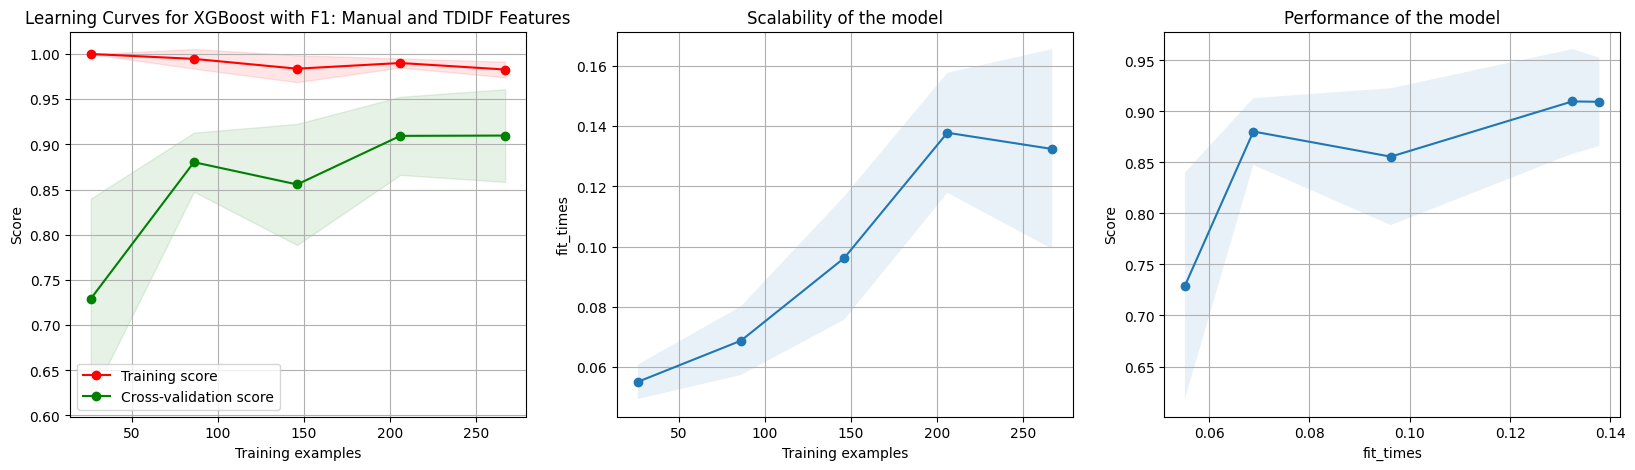

In [59]:
plot_learning_curve(
    best_estimator_pipeline3,
    'Learning Curves for XGBoost with F1: Manual and TDIDF Features',
    X_train_combo,
    y_train_combo,
    scoring = 'f1_macro',
    n_jobs = -1)

### **<font color='Pickle'>Observations</font>**

- **<font color='Pickle'>Learning Curve:</font>**  
  This model still shows indication of **<font color='indianred'>overfitting.</font>**
 This is because of the model nearly perfectly fitting the training data. However we can see a consistent increase in the **<font color='Pickle'>CV</font>** scores of the validation data and a slight decrease in the **<font color='Pickle'>training score</font>**, indicating that this model may have the best generalization of the three despite being more complex.

- **<font color='Pickle'>Scalability of the Model:</font>**  
  As with the first model we can see a general upward and steady trend of fit times as the training examples increase. The fit times are slightly larger and have higher varaibility as the training examples increase than the other two models which can cause a bit of concern. However, in a limited compute environment the ability to generalize will hold a bit more weight since the fit times are not significantly higher.

- **<font color='Pickle'>Performance of the Model:</font>**  
We can see a steady improvement in model performance overall as the fit times increase. We can also see a slight taper in the shaded area of the graph as we move to the left, suggesting that as the fit times and data increase the model becomes more stable.

###<font color = 'Pickle'>**CV and Train Score:**

In [60]:
# Checking train
print(best_estimator_pipeline3.score(X_train_combo,y_train_combo))

#checking CV
print(complete_grid_pipeline3.best_score_)

0.9940119760479041
0.9364192305701156


###<font color = 'Pickle'>**Evaluating on the test set:**

In [61]:
def final_pipeline(text):
  cleaned_text = joblib.load(file_X_test_cleaned_s) #pulling in the cleaned tfidf data from pipeline1
  X_features, feature_names = featurizer.fit_transform(text)
  X_combo = pd.concat((pd.DataFrame(cleaned_text,columns = ['cleaned_text']),
                       pd.DataFrame(X_features, columns = feature_names)),axis = 1)
  best_estimator_pipeline3 = joblib.load(file_best_estimator_pipeline3)
  predictions = best_estimator_pipeline3.predict(X_combo)
  return predictions

In [62]:
# predicting the final values using the testing set
y_test_pred_combo = final_pipeline(X_test_combo)

###<font color = 'Pickle'>**Classification Report:**

In [63]:
print('\nTest set classification report:\n\n',
      classification_report(y_test_combo, y_test_pred_combo))


Test set classification report:

               precision    recall  f1-score   support

           0       0.98      0.95      0.97       187
           1       0.79      0.92      0.85        36

    accuracy                           0.95       223
   macro avg       0.88      0.93      0.91       223
weighted avg       0.95      0.95      0.95       223



### **<font color='Pickle'>Model Interpretation Summary</font>**

- **<font color='Pickle'>Class 0 (Ham - Majority Class):</font>**
  - **<font color='Pickle'>Precision: 0.98</font>** – The model correctly identifies 98% of ham emails, making it highly reliable in avoiding false positives for legitimate, non-spam emails.
  - **<font color='Pickle'>Recall: 0.95</font>** – It captures the vast majority of ham emails, missing only 5%, which is excellent coverage.
  - **<font color='Pickle'>F1-Score: 0.97</font>** – The balance between precision and recall is strong, giving an overall F1-score of 0.97. This shows excellent performance on the majority class.

- **<font color='Pickle'>Class 1 (Spam - Minority Class):</font>**
  - **<font color='Pickle'>Precision: 0.79</font>** – When the model predicts an email as spam, it’s accurate 79% of the time. However, there are still some false positives, meaning 21% of emails flagged as spam are actually ham.
  - **<font color='Pickle'>Recall: 0.92</font>** – It successfully identifies 92% of the actual spam emails, showing strong spam-catching ability, though there’s still a little room for improvement.
  - **<font color='Pickle'>F1-Score: 0.85</font>** – The balance between precision and recall here gives us an F1-score of 0.85. This reflects solid handling of spam, but there’s still a chance for better performance.

### **<font color='Pickle'>Overall Takeaway:</font>**

- **<font color='Pickle'>Majority Class (Ham) Performance:</font>** The model is spot-on when it comes to identifying ham emails, with both precision and recall near perfect. Legitimate emails are rarely misclassified, making this a big win for accuracy and user experience.
  
- **<font color='Pickle'>Spam Detection (Minority Class):</font>** The model does a great job catching most spam emails, but with slightly lower precision, meaning some legitimate emails still get flagged as spam. The strong F1-score of 0.85 shows we’ve struck a good balance between catching spam and minimizing false positives.

- **<font color='Pickle'>Watch Out for Overfitting:</font>** Despite the high overall performance, the slightly uneven handling of the minority class suggests some potential overfitting. This could impact generalization on unseen data, so it’s worth keeping an eye on as more data is tested.

### **<font color='Pickle'>Performance Metrics Summary:</font>**
- **<font color='Pickle'>Accuracy:</font>** 95%
- **<font color='Pickle'>Macro Average F1-Score:</font>** 0.91
- **<font color='Pickle'>Weighted Average F1-Score:</font>** 0.95



#<font color = "Pickle">**Final Model Choice**
- <font color = 'Pickle'>**TFIDF + Manual Features (combo) Pipeline:**</font>
  - The primary reason for this choice is the larger potential for variablity in hyperparameter tuning and the increase in model performance over time. I was caught between using the Manual features only or this pipeline because they both have <font color = "pickle">**F1-Scores**</font> of 0.85 for the <font color = "pickle">**spam**</font>  class and 0.97 for the <font color = "pickle">**ham**</font> class. Both models suffer from overfitting but the we can see a trend of the gap between the CV scores and training scores decrease more as more samples are added for the <font color = "pickle">**combination**</font>  pipeline.